<a href="https://colab.research.google.com/github/boyamie/PaperReview/blob/main/CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 목차

1. CLIP 모델을 다운로드하고 실행하는 방법
2. 임의의 이미지와 텍스트 입력 간의 유사도를 계산하는 방법
3. 제로샷 이미지 분류를 수행하는 방법을 보여줍니다.

# Preparation for Colab

Runtime > Change Runtime Type을 선택하여 하드웨어 가속기를 "GPU"로 설정한다.
clip 패키지와 그 종속성을 설치하고, PyTorch 1.7.1 이상이 설치되었는지 확인한다.

In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 615.2 kB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-_dygrb_9
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-_dygrb_9
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x8

In [ ]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)


Torch version: 2.2.1+cu121


# Loading the model

`clip.available_models()` 사용 가능한 CLIP 모델의 이름을 리스트로 반환

In [ ]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [ ]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 68.4MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

입력 이미지를 모델이 기대하는 이미지 해상도에 맞추기 위해 크기를 조정하고 중심을 자른다. 이 작업을 수행하기 전에, 데이터셋의 평균과 표준 편차를 사용하여 픽셀 강도를 정규화한다.

clip.load() 함수의 두 번째 반환 값은 이러한 전처리를 수행하는 torchvision Transform을 포함하고 있다.



In [ ]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x79e73f943250>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

clip.tokenize()는 문자열을 토큰으로 변환하는 함수이다. CLIP 모델이 기대하는 입력 형식으로 변환한다.

In [ ]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# Setting up input images and texts

8개의 예제 이미지와 그 텍스트 설명을 모델에 입력한 후, 해당 특징 간의 유사성을 비교한다.

토크나이저는 대소문자를 구분하지 않으며, 적절한 텍스트 설명을 자유롭게 제공할 수 있다.

In [ ]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer"
}

In [ ]:
# skimage 데이터 확인
# len(os.listdir(skimage.data_dir)) # 30
# filename = os.listdir(skimage.data_dir)

# filename = [image for image in filename if image.endswith(".png") or image.endswith(".jpg")]
# filename # 26장의 이미지

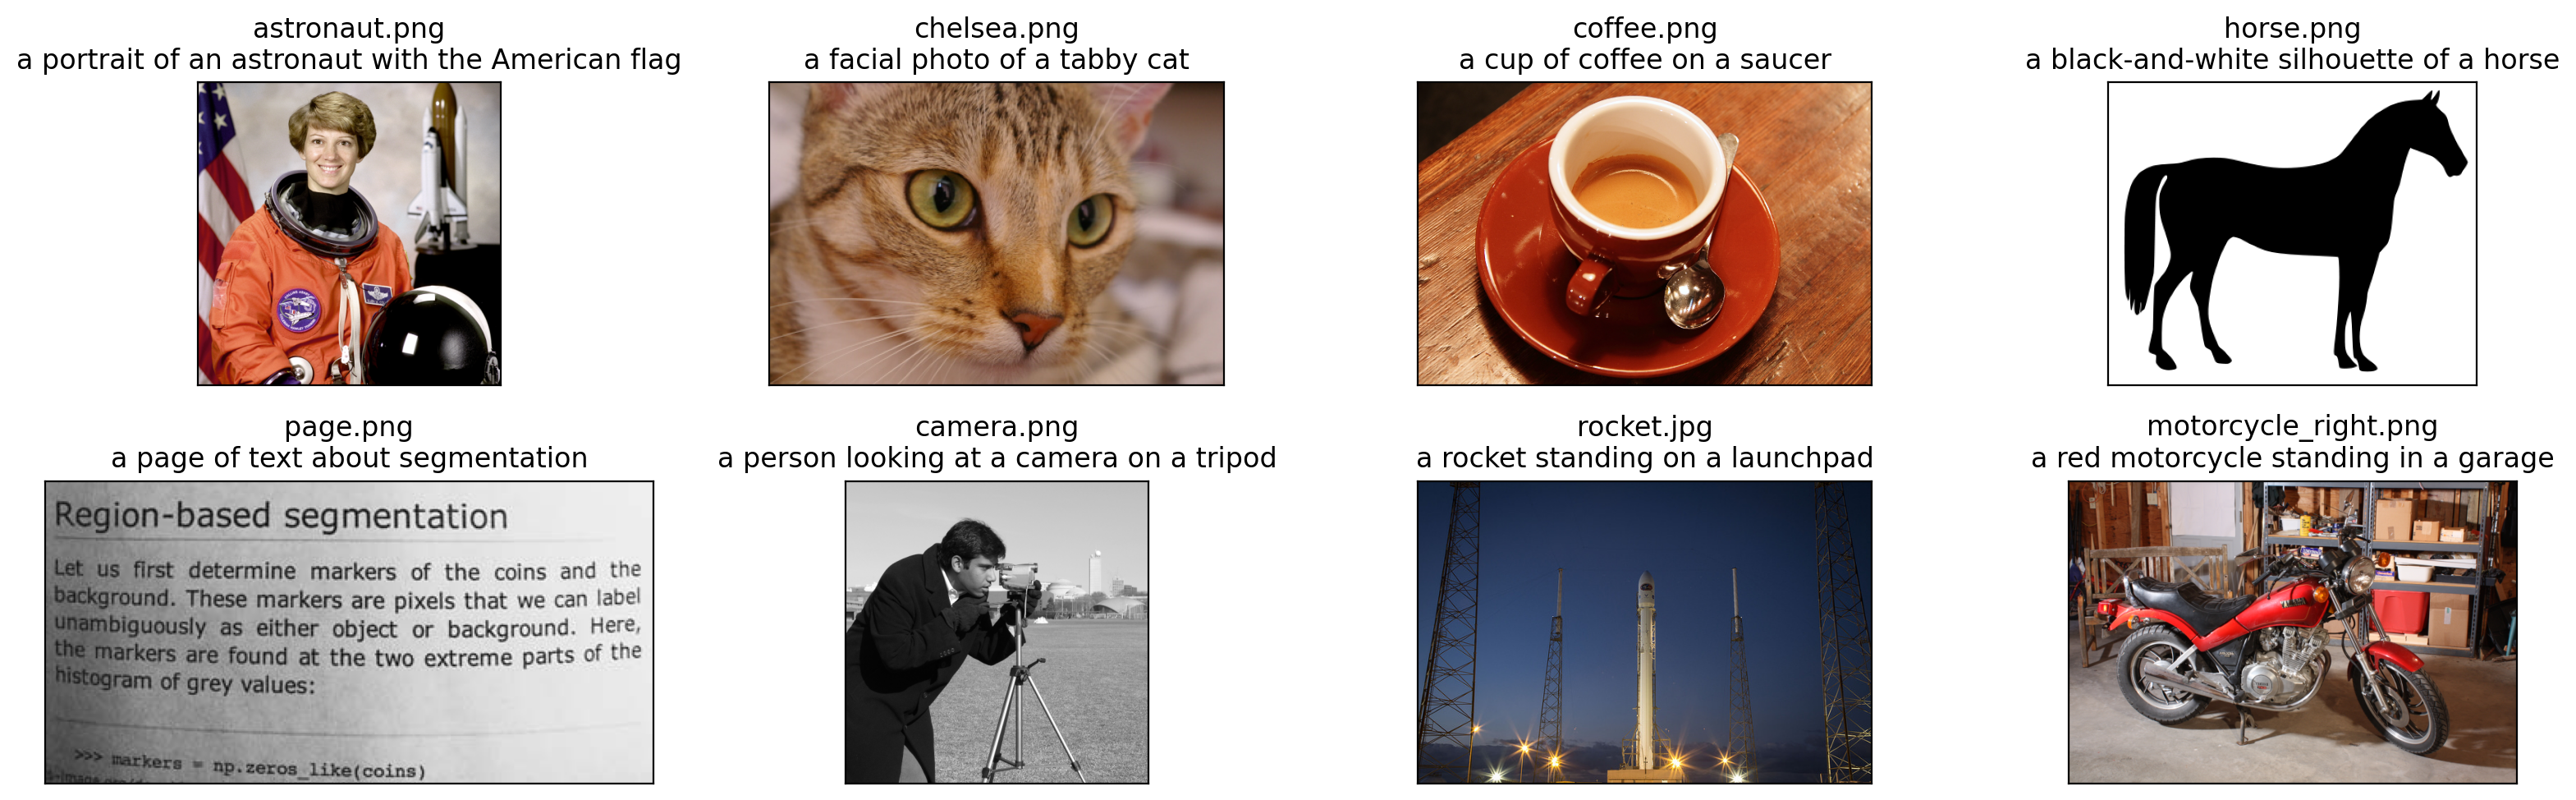

In [ ]:
original_images = [] # skimage의 원본 image
images = [] # preprocessed image가 들어감
texts = [] # description(prompt)가 들어감, 만약 image의 이름이 coffee면 "a cup of coffee on a saucer"
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()


## Building features


이미지를 정규화하고 각 텍스트 입력을 토큰화한 다음, 모델의 순전파를 실행하여 이미지와 텍스트 특징을 얻는다.

In [ ]:
# image set 확인
batch = np.stack(images)
print(f"dimension : {batch.ndim}, shape: {batch.shape}")

dimension : 4, shape: (8, 3, 224, 224)


In [ ]:
# text set 확인
sentence = ["This is " + desc for desc in texts]
print(sentence[0])
sen_to_tok = clip.tokenize(sentence)
print(sen_to_tok[0])
print(sen_to_tok.ndim) # 2
print(sen_to_tok.shape) # (8, 77)

This is a portrait of an astronaut with the American flag
tensor([49406,   589,   533,   320,  5352,   539,   550, 18376,   593,   518,
         2151,  4859, 49407,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0], dtype=torch.int32)
2
torch.Size([8, 77])


In [ ]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [ ]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

## Calculating cosine similarity

특징을 정규화한 다음, 각 쌍의 특징 간의 내적(점곱)을 계산합니다.

In [ ]:
# image_features와 text_features의 shape 확인 => whether they share the same embedding space
print(image_features.shape) # [8, 512]
print(text_features.shape) # [8, 512]

torch.Size([8, 512])
torch.Size([8, 512])


In [ ]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
print(similarity)

[[0.276764   0.16811681 0.14953461 0.16265653 0.12996227 0.16582617
  0.22073916 0.15013461]
 [0.11960865 0.30741104 0.16607127 0.15256464 0.1208591  0.1596784
  0.11878991 0.12491632]
 [0.14814067 0.18379952 0.2930898  0.15400442 0.1437191  0.17419636
  0.12266819 0.12159108]
 [0.11462487 0.14569373 0.15417069 0.34598106 0.1725612  0.21314073
  0.1487259  0.16737938]
 [0.14676848 0.20106556 0.19833222 0.20000333 0.35391587 0.20149976
  0.15956287 0.16312867]
 [0.18585536 0.20821352 0.13662991 0.19504192 0.18864024 0.30479845
  0.20692638 0.1607168 ]
 [0.19189939 0.17756954 0.13830814 0.1698535  0.1741471  0.20163749
  0.30291963 0.15816064]
 [0.15480246 0.15410961 0.12521824 0.16220488 0.14272468 0.11985052
  0.15933995 0.32057947]]


In [ ]:
print(similarity.shape) # 8 x 8

(8, 8)


In [ ]:
# image_features와 text_features, similarty의 shape 확인(2)
# Normalization 후 변화 확인
print(image_features.shape)
print(text_features.shape)
print(similarity.shape)

torch.Size([8, 512])
torch.Size([8, 512])
(8, 8)


Text(0.5, 1.0, 'Cosine similarity between text and image features')

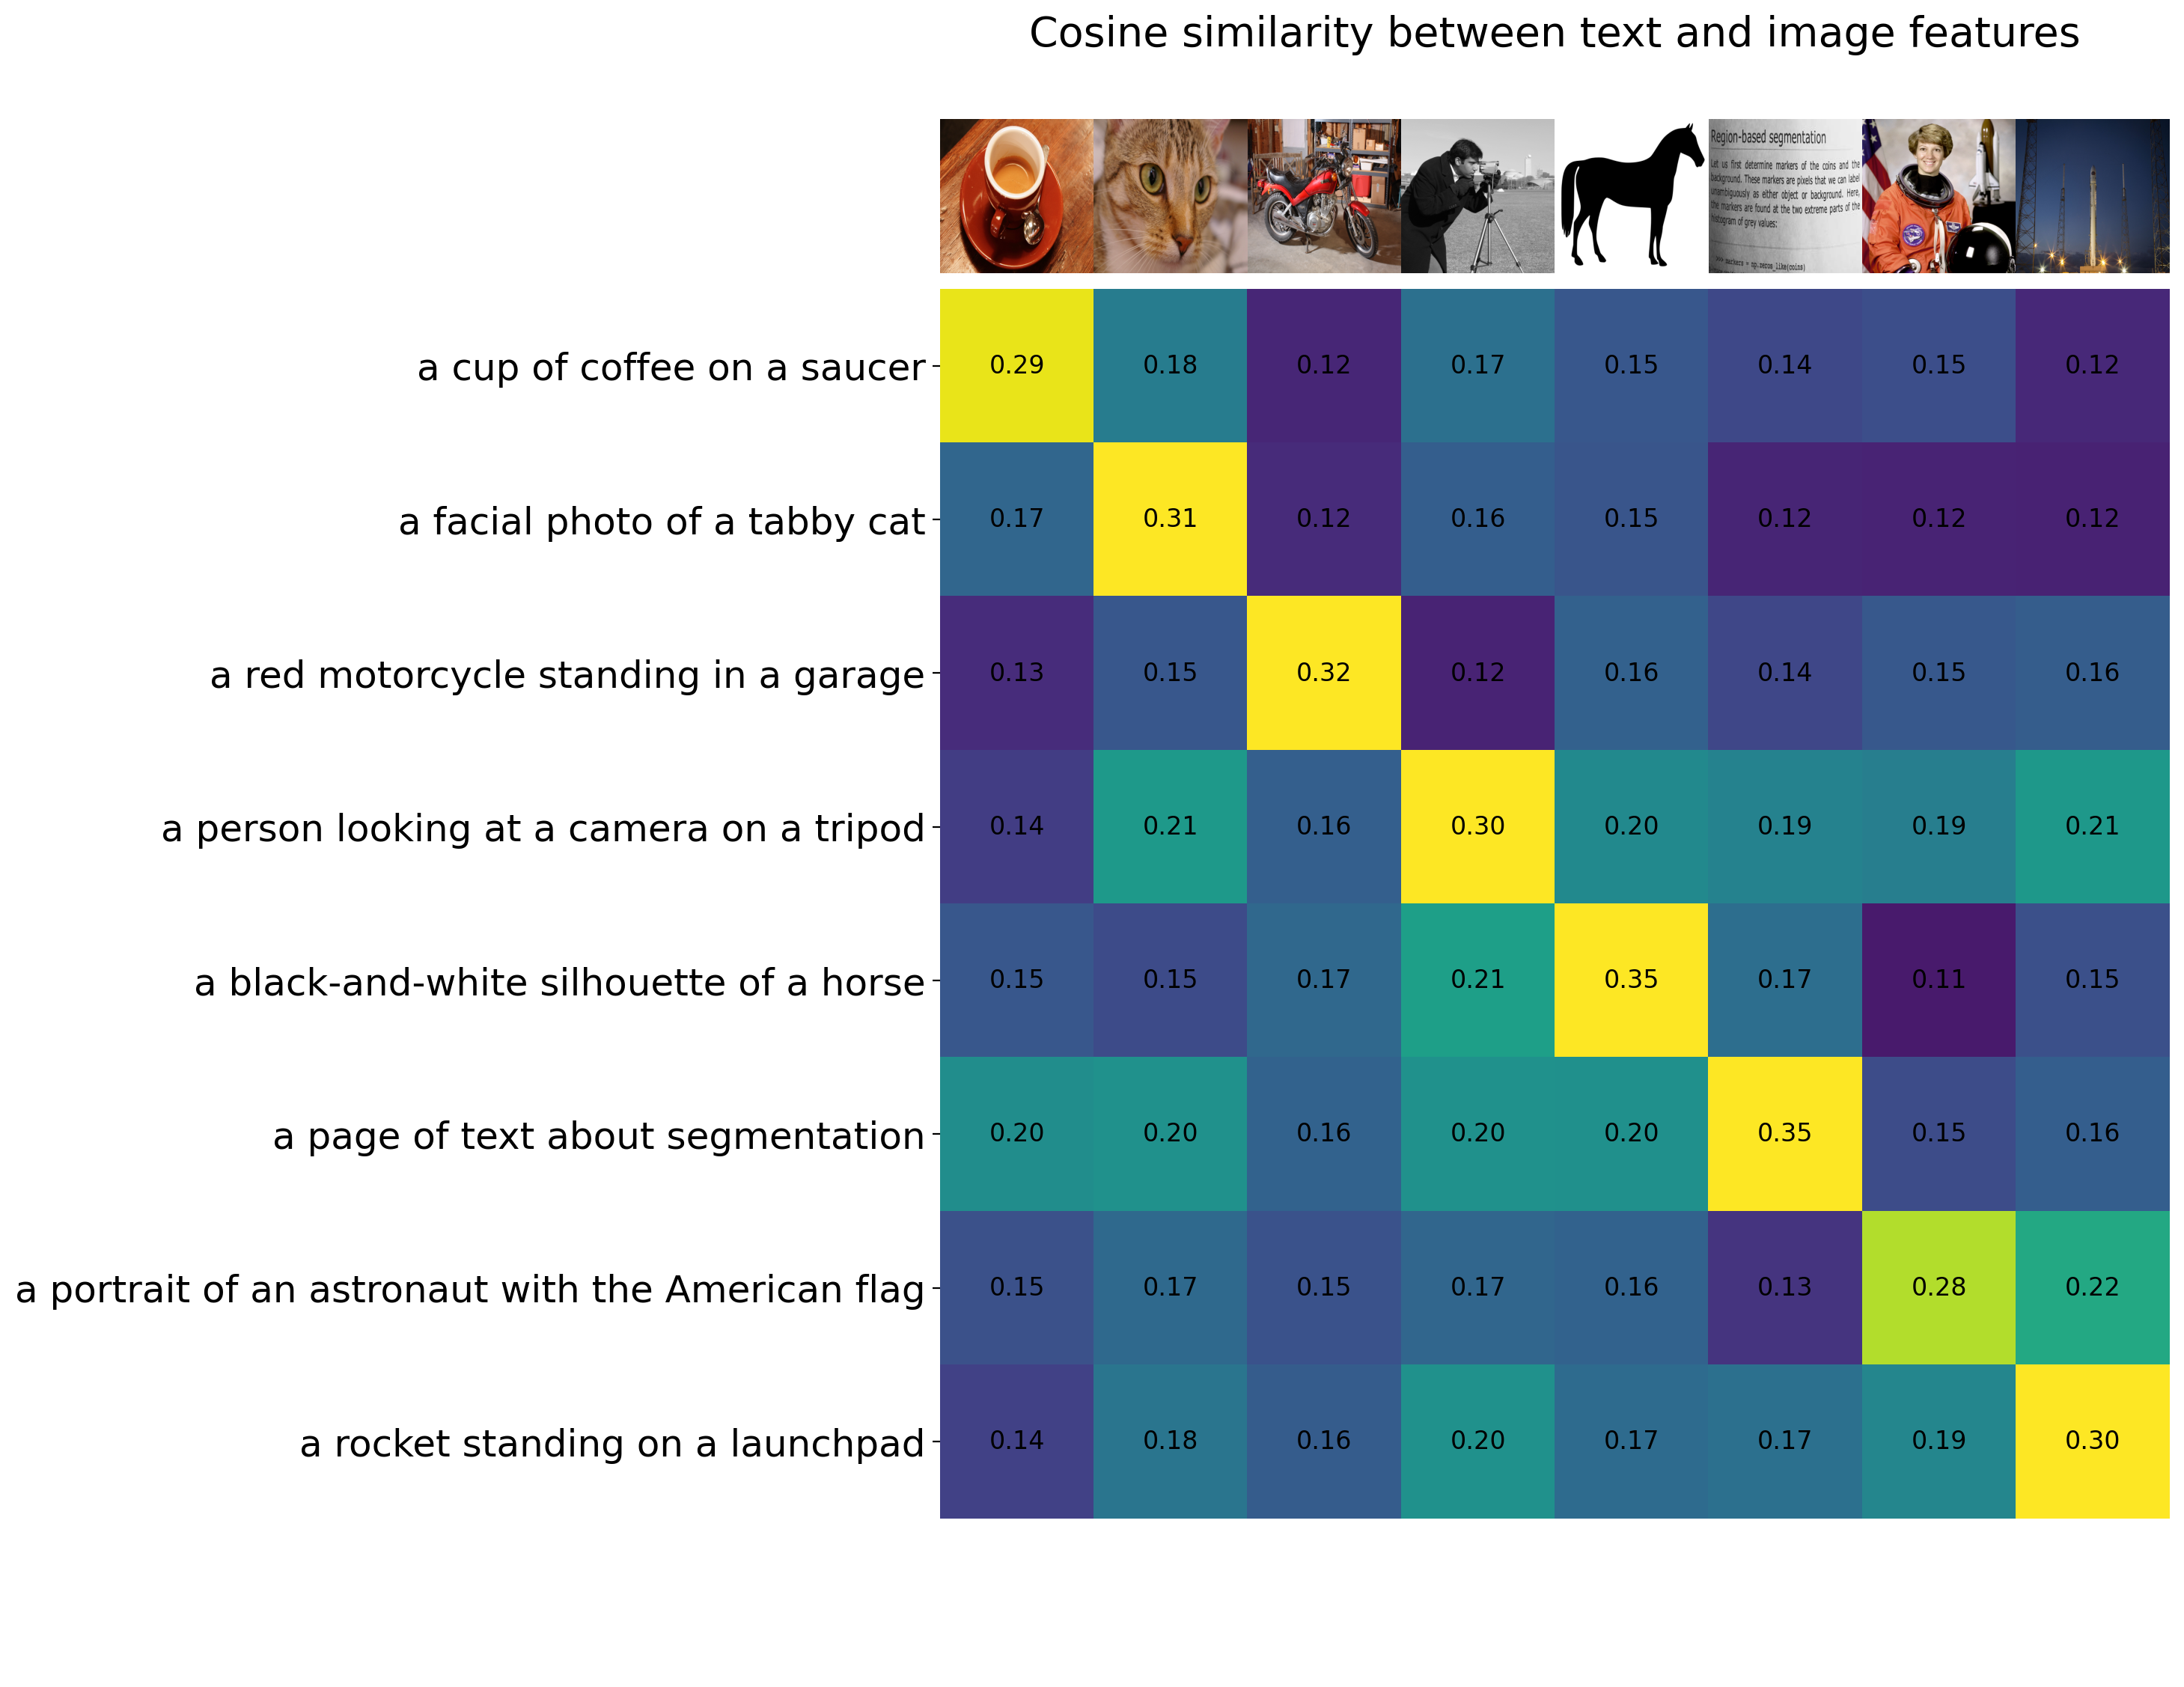

In [ ]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

# Zero-Shot Image Classification

코사인 유사도(100을 곱한 값)를 소프트맥스 연산의 로짓(logits)으로 사용하여 이미지를 분류할 수 있다.

In [ ]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

100%|██████████| 169001437/169001437 [00:13<00:00, 12994818.33it/s]


Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


In [ ]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [ ]:
len(text_descriptions)

100

In [ ]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

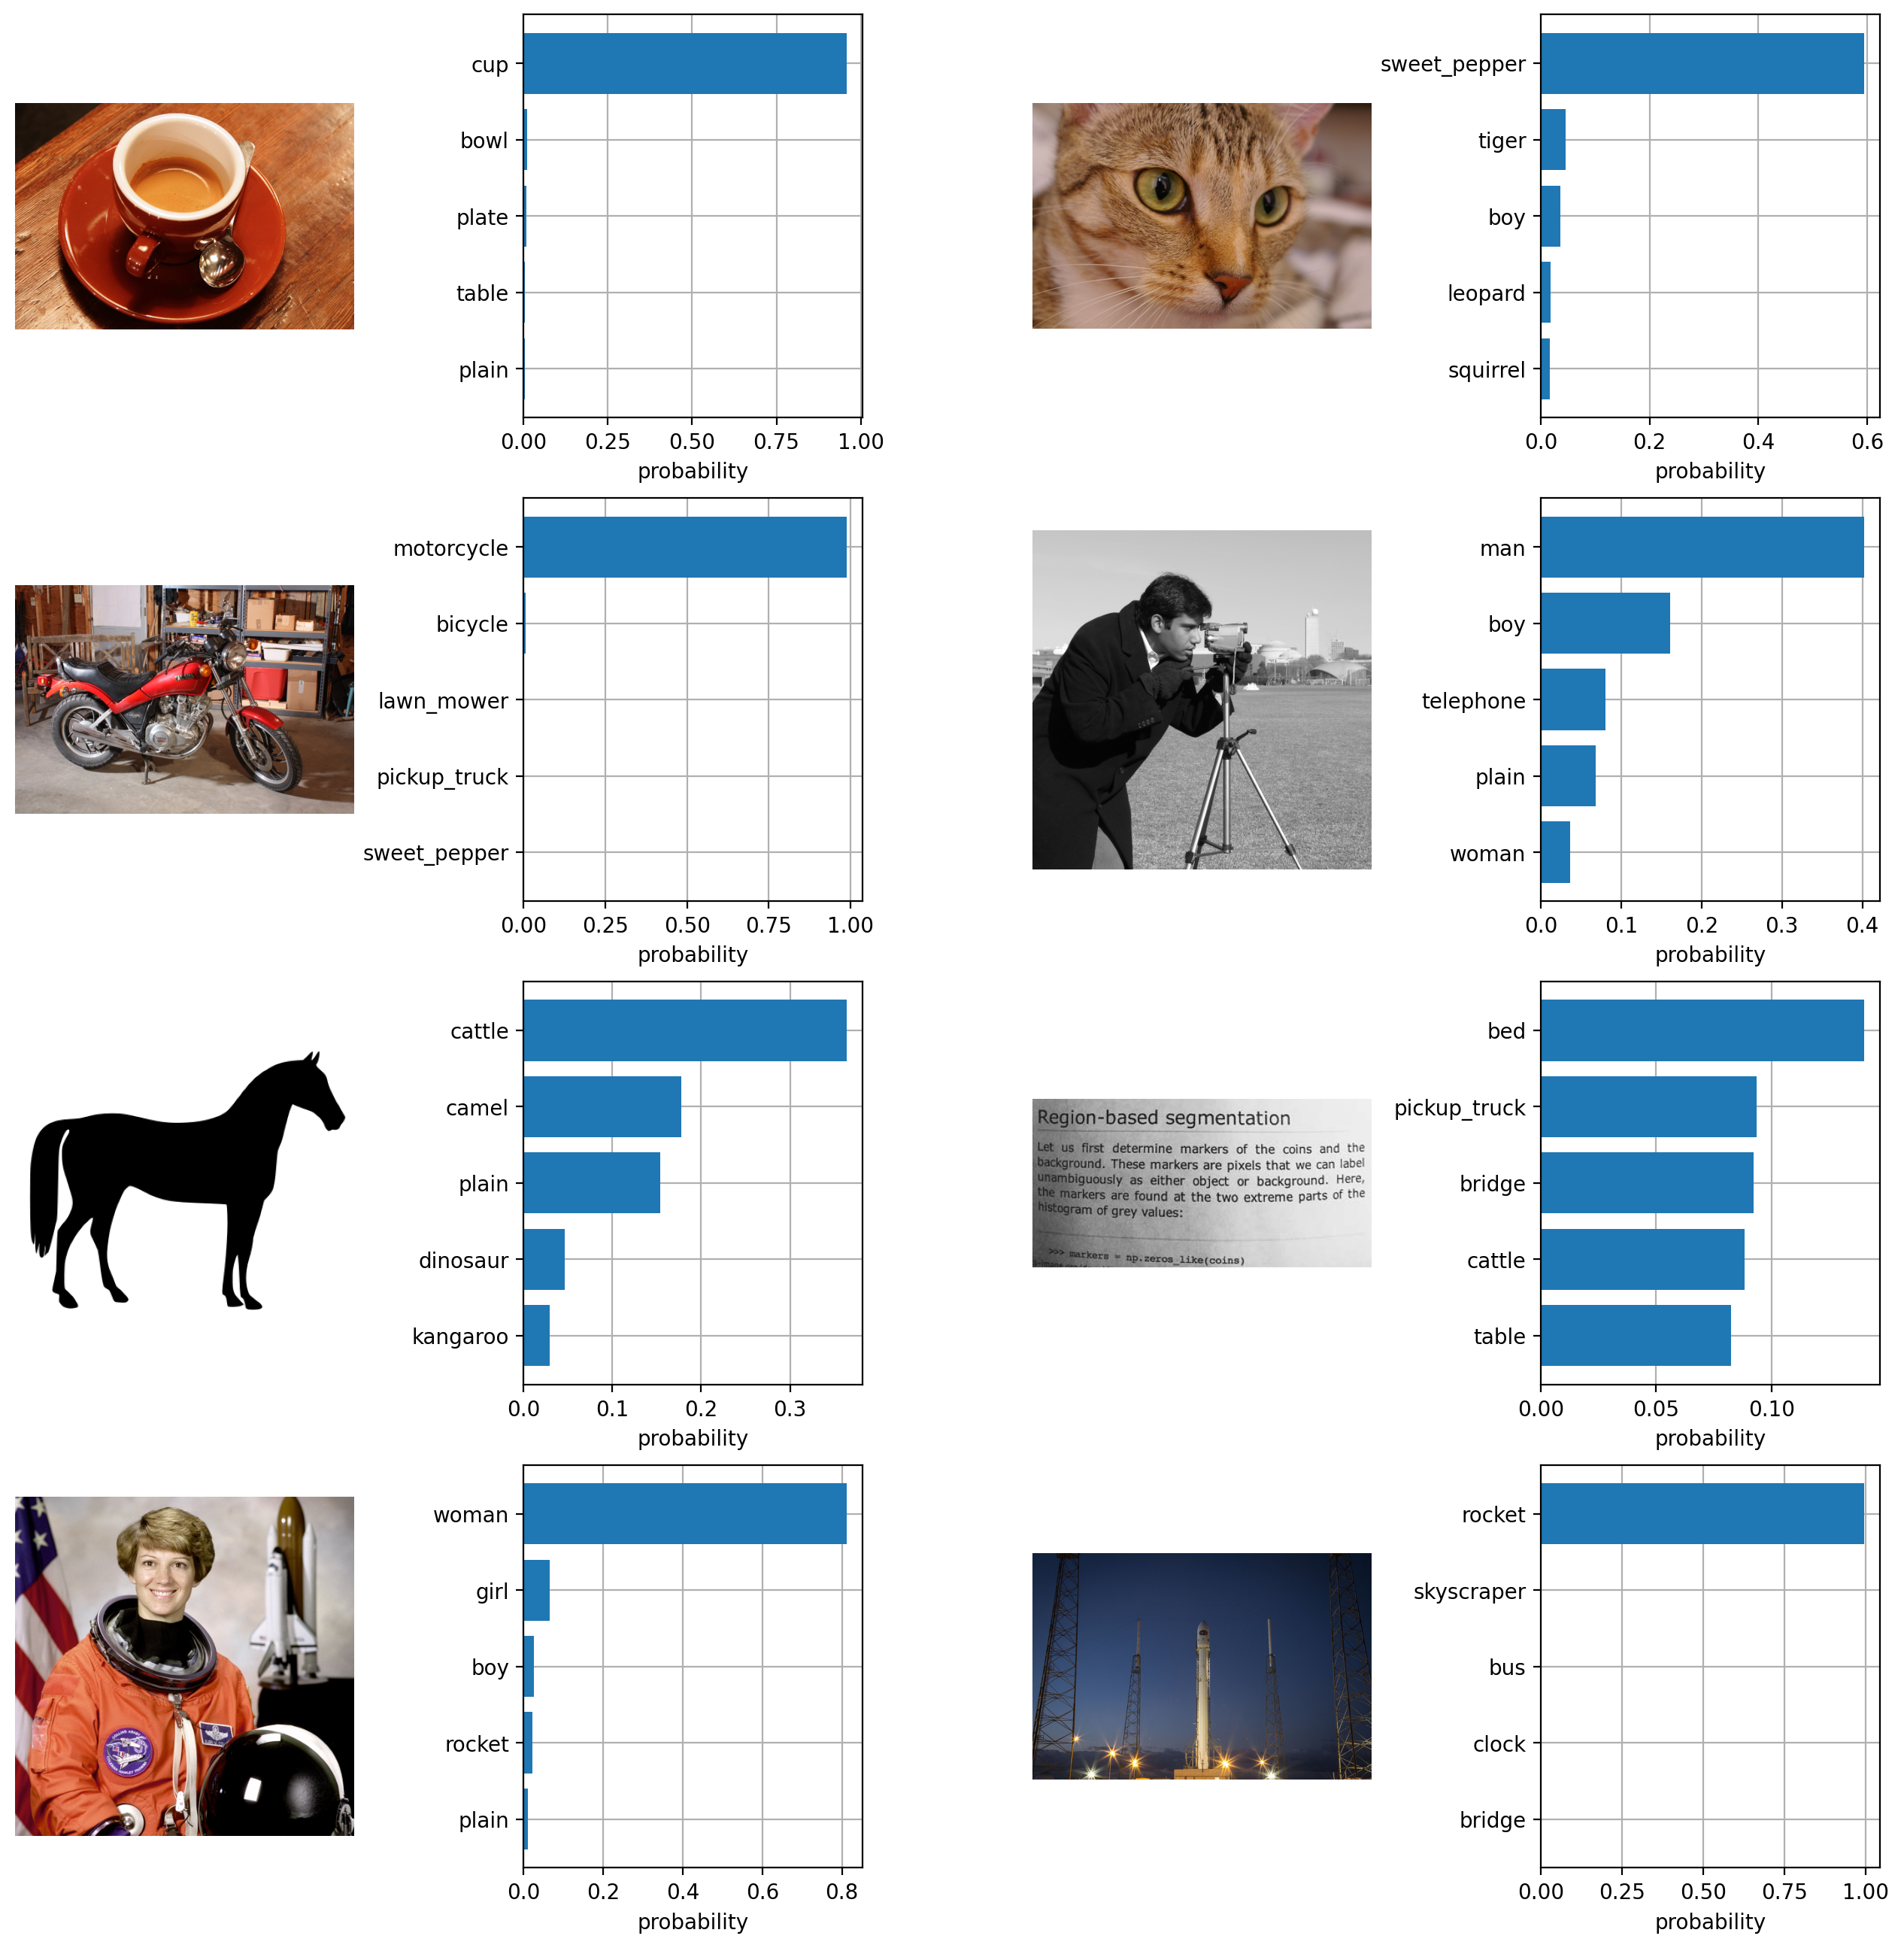

In [ ]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()